In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from cnn_utils import *

Using TensorFlow backend.


In [2]:
train = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/CNN/dataset/sign_mnist_train.csv")
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [3]:
X_train = X_train / 255.0
print("x_train shape: ",X_train.shape)
print("y_train shape: ",Y_train.shape)

x_train shape:  (27455, 784)
y_train shape:  (27455,)


In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (24709, 784)
x_val shape (2746, 784)
y_train shape (24709,)
y_val shape (2746,)


In [5]:
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("x_val shape: ",X_val.shape)

x_train shape:  (24709, 28, 28, 1)
x_val shape:  (2746, 28, 28, 1)


In [6]:
Y_train = to_categorical(Y_train, num_classes = 25)
Y_val = to_categorical(Y_val, num_classes = 25)
print("y_train shape: ",Y_train.shape)
print("y_val shape: ",Y_val.shape)

y_train shape:  (24709, 25)
y_val shape:  (2746, 25)


In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32,shape=[None, n_H0, n_W0, n_C0], name = "X")
    Y = tf.placeholder(tf.float32,shape=[None, n_y], name = "Y")
    
    return X, Y

In [8]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
                        W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    W1 = tf.Variable(tf.glorot_uniform_initializer()((4, 4, 1, 8)))
    W2 = tf.Variable(tf.glorot_uniform_initializer()((2, 2, 8, 16)))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.compat.v1.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 25 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.compat.v1.layers.dense(F, 25,activation=None)

    return Z3

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 25)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels = Y,logits = Z3))
    
    return cost

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 200, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 28, 28, 1)
    Y_train -- test set, of shape (None, n_y = 25)
    X_test -- training set, of shape (None, 28, 28, 1)
    Y_test -- test set, of shape (None, n_y = 25)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 200 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                _ , temp_cost = sess.run(fetches=[optimizer, cost],feed_dict={X: minibatch_X,Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Val Accuracy:", test_accuracy)
        # Save the variables to disk
        save_path = tf.train.Saver().save(sess, "/tmp/model.ckpt")
        print (f"Variables saved in path: {save_path}")
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
                
        return train_accuracy, test_accuracy, parameters

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Cost after epoch 0: 2.319492
Cost after epoch 5: 0.854238
Cost after epoch 10: 0.660266
Cost after epoch 15: 0.543982
Cost after epoch 20: 0.471656
Cost after epoch 25: 0.428179
Cost after epoch 30: 0.398600
Cost after epoch 35: 0.375422
Cost after epoch 40: 0.362920
Cost after epoch 45: 0.353194
Cost after epoch 50: 0.345035
Cost after epoch 55: 0.329205
Cost after epoch 60: 0.318409
Cost after epoch 65: 0.314320
Cost after epoch 70: 0.305447
Cost after epoch 75: 0.298267
Cost after epoch 80: 0.296514
Cost after epoch 85: 0.288466
Cost after epoch 90: 0.282164
Cost after epoch 95: 0.282209
Cost after epoch 100: 0.279826
Cost after epoch 105: 0.281091
Cost after epoch 110: 0.274188
Cost after epoch 115: 0.275421
Cost after epoch 120: 0.272001
Cost afte

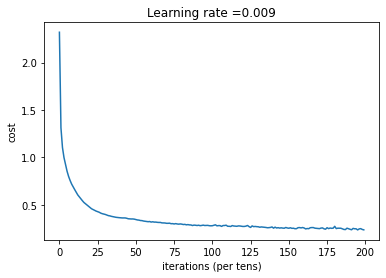

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9210409
Val Accuracy: 0.91551346
Variables saved in path: /tmp/model.ckpt
Parameters have been trained!


In [12]:
_, _, parameters = model(X_train, Y_train, X_val, Y_val)

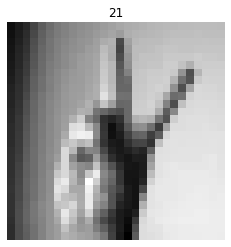

In [13]:
test1 = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/CNN/dataset/sign_mnist_test.csv")
X_test1 = test1.drop(labels = ["label"],axis = 1)
img = X_test1.iloc[5].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(test1.iloc[5,0])
plt.axis("off")
plt.show()

In [14]:
X_test1=X_test1/ 255.0
my_image_prediction = predict(X_test1.iloc[5].values.reshape((-1,28,28,1)), parameters)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))






Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Your algorithm predicts: y = 21
